In [25]:
#reload source files automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import pandas as pd
import matplotlib.pyplot as plt

from event_clustering.preprocessing import *
from event_clustering.clustering import *
from event_clustering.feature_engineering import *
from event_clustering.postprocessing import *
from event_clustering.process_mining import *

from sklearn.cluster import *
import sklearn.metrics as metrics
import scipy.cluster.hierarchy as sch

# Loading Preprocessing Analyzing

In [27]:
file_name = 'DomesticDeclarations'
df = preprocess(load('data/' + file_name + '.xes'))
original_df_columns = df.columns

In [28]:
analyze(df)
df.head(10)

column name: case:Amount
data type: <class 'numpy.float64'>
unique values: 8326


column name: case:BudgetNumber
data type: <class 'str'>
unique values: 1


column name: case:DeclarationNumber
data type: <class 'str'>
unique values: 10049


column name: case:concept:name
data type: <class 'str'>
unique values: 10500


column name: case:id
data type: <class 'str'>
unique values: 10500


column name: concept:name
data type: <class 'str'>
unique values: 17


column name: id
data type: <class 'str'>
unique values: 56437


column name: org:resource
data type: <class 'str'>
unique values: 2


column name: org:role
data type: <class 'str'>
unique values: 7


column name: time:timestamp
data type: <class 'datetime.datetime'>
unique values: 45403


min case length: size    1
dtype: int64
max case length: size    24
dtype: int64
mode case length:    size
0     5
mean case length: size    5.374952
dtype: float64


,case:Amount,case:BudgetNumber,case:DeclarationNumber,case:concept:name,case:id,concept:name,id,org:resource,org:role,time:timestamp
0,26.851205,budget 86566,declaration number 86792,declaration 86791,declaration 86791,Declaration SUBMITTED by EMPLOYEE,st_step 86794_0,STAFF MEMBER,EMPLOYEE,2017-01-09 09:49:50+01:00
1,182.464172,budget 86566,declaration number 86796,declaration 86795,declaration 86795,Declaration SUBMITTED by EMPLOYEE,st_step 86798_0,STAFF MEMBER,EMPLOYEE,2017-01-09 10:26:14+01:00
2,320.646137,budget 86566,declaration number 86801,declaration 86800,declaration 86800,Declaration SUBMITTED by EMPLOYEE,st_step 86804_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:13:33+01:00
3,113.862047,budget 86566,declaration number 86732,declaration 86731,declaration 86731,Declaration SUBMITTED by EMPLOYEE,st_step 86733_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:24:20+01:00
4,26.851205,budget 86566,declaration number 86792,declaration 86791,declaration 86791,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86793_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:27:48+01:00
5,134.404169,budget 86566,declaration number 86736,declaration 86735,declaration 86735,Declaration SUBMITTED by EMPLOYEE,st_step 86738_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:30:26+01:00
6,134.404169,budget 86566,declaration number 86736,declaration 86735,declaration 86735,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86737_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:37:18+01:00
7,113.862047,budget 86566,declaration number 86732,declaration 86731,declaration 86731,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86734_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:37:23+01:00
8,443.585163,budget 86566,declaration number 86806,declaration 86805,declaration 86805,Declaration SUBMITTED by EMPLOYEE,st_step 86807_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:40:47+01:00
9,443.585163,budget 86566,declaration number 86806,declaration 86805,declaration 86805,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86808_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:41:23+01:00


# Feature Generation

In [ ]:
add_event_type_representative(df)

In [ ]:
add_event_ref(df, 1)
add_event_ref(df, 2)
add_event_ref(df, 3)
add_event_ref(df, -1)
add_event_ref(df, -2)
add_event_ref(df, -3)

In [300]:
add_timestamp_features(df)

In [302]:
df.to_csv('data/' + file_name +'_features.csv', index=False)

In [299]:
df = preprocess(pd.read_csv('data/' + file_name +'_features.csv'))

In [311]:
df_vectorized

,concept:name_administration,concept:name_approved,concept:name_budget,concept:name_declaration,concept:name_employee,concept:name_final_approved,concept:name_for_approval,concept:name_handled,concept:name_missing,concept:name_owner,...,concept:name_submitted,concept:name_supervisor,org:role_ADMINISTRATION,org:role_BUDGET OWNER,org:role_EMPLOYEE,org:role_MISSING,org:role_PRE_APPROVER,org:role_SUPERVISOR,org:role_UNDEFINED,feature_hour
0,0.000000,0.000000,0.0,0.373627,0.639840,0.00000,0.0,0.000000,0.000000,0.0,...,0.671571,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9
1,0.000000,0.000000,0.0,0.373627,0.639840,0.00000,0.0,0.000000,0.000000,0.0,...,0.671571,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10
2,0.000000,0.000000,0.0,0.373627,0.639840,0.00000,0.0,0.000000,0.000000,0.0,...,0.671571,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11
3,0.000000,0.000000,0.0,0.373627,0.639840,0.00000,0.0,0.000000,0.000000,0.0,...,0.671571,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11
4,0.000000,0.000000,0.0,0.352467,0.000000,0.66522,0.0,0.000000,0.000000,0.0,...,0.000000,0.658217,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11
5,0.000000,0.000000,0.0,0.373627,0.639840,0.00000,0.0,0.000000,0.000000,0.0,...,0.671571,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11
6,0.000000,0.000000,0.0,0.352467,0.000000,0.66522,0.0,0.000000,0.000000,0.0,...,0.000000,0.658217,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11
7,0.000000,0.000000,0.0,0.352467,0.000000,0.66522,0.0,0.000000,0.000000,0.0,...,0.000000,0.658217,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11
8,0.000000,0.000000,0.0,0.373627,0.639840,0.00000,0.0,0.000000,0.000000,0.0,...,0.671571,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11
9,0.000000,0.000000,0.0,0.352467,0.000000,0.66522,0.0,0.000000,0.000000,0.0,...,0.000000,0.658217,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11


# Encoding

In [238]:
#df_cn = tfidf_encode(df, 'activityNameEN', TfidfVectorizer(stop_words = 'english'))
#df_role = one_hot_encode(df, 'org:resource')

In [323]:
df_cn = tfidf_encode(df, 'concept:name', TfidfVectorizer(stop_words = 'english'))
df_role = one_hot_encode(df, 'org:role')
df_next = one_hot_encode(df, 'nevent_1')
df_next2 = one_hot_encode(df, 'nevent_2')
df_next3 = one_hot_encode(df, 'nevent_3')
#df_time_previous = one_hot_encode(df, 'feature_time_since_-1')

In [324]:
df_vectorized = df_cn
df_vectorized = df_vectorized.join(df_role)
df_vectorized = df_vectorized.join(df_next)
df_vectorized = df_vectorized.join(df_next2)
df_vectorized = df_vectorized.join(df_next3)
#df_vectorized = df_vectorized.join(df['feature_day_nr'])

In [282]:
for c in [-2,-1,1,2,3]:
    df_vectorized = df_vectorized.join(df['nevent_time_' +str(c)])

# Clustering
* KMeans
* Hierarchical (Agglomerative)

### KMeans

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters


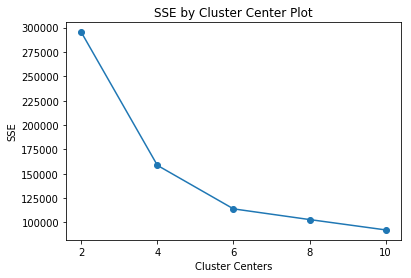

In [307]:
find_optimal_clusters(df_vectorized, 10)

In [325]:
cluster_nr = 6
km = MiniBatchKMeans(n_clusters=cluster_nr, init_size=1024, batch_size=2048, random_state=20)
clusters_km = km.fit_predict(df_vectorized)

### Hierarchical Clustering

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
hier_dendogram = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage = "single").fit(df_vectorized)

# Plot the corresponding dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
#plot_dendrogram(hier_dendogram, truncate_mode='level', p=5)
plt.xlabel("Sample Index or (Cluster Size)")
plt.ylabel("Distance")
plt.show()

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(hier_dendogram, truncate_mode='level', p=40)
plt.xlabel("Sample Index or (Cluster Size)")
plt.ylabel("Distance")
plt.show()

In [ ]:
# --> determine amount of clusters
agg_clusters = 3
hier = AgglomerativeClustering(n_clusters=agg_clusters, linkage="single").fit(df_vectorized)

## Evaluation

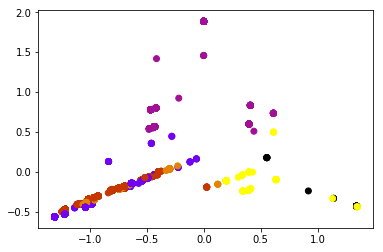

In [326]:
kmeans = True
hierarchical = False

if kmeans:
    plot_pca(df_vectorized, clusters_km, cluster_nr)

if hierarchical:
    plot_pca(df_vectorized, hier.labels_, cluster_nr)

In [327]:
if kmeans:
    print("Silhouette Coefficient KMeans: ", metrics.silhouette_score(df_vectorized, clusters_km))

if hierarchical:
    print("Silhouette Coefficient Hierarchical Clustering: ", metrics.silhouette_score(df_vectorized, hier.labels_))

Silhouette Coefficient KMeans:  0.734592083297963


In [ ]:
# https://en.wikipedia.org/wiki/Cophenetic_correlation? --> for hierarchical clustering maybe?

In [ ]:
# !!! have to load df every time new, other wise there are just the representatives in the dataframe
# df = preprocess(load(file_path))

# set cluster label as a column in the original df

kmeans = True
hierarchical = False

if kmeans:
    df_km = add_cluster_label_km(df, df_vectorized, km)
if hierarchical:
    df_hier = add_cluster_label_hier(df, df_vectorized, hier)
df.head(5)

## Check cluster labels "manually"

In [ ]:
#eval_manually = df_km.groupby('cluster_label')['activityNameEN'].apply(set)

In [ ]:
# group by cluster label and aggregate concept:name
eval_manually = df_hier.groupby('cluster_label')['concept:name'].apply(set)

In [ ]:
pd.set_option('display.max_colwidth', -1)
eval_manually

## Replace events with cluster representative

In [ ]:
# overwrite activityNameEN with mapped cluster representative
#abstracted_df = replace_with_representative(df_km, "activityNameEN", "cluster_label", original_df_columns)
#abstracted_df.head(5)

In [ ]:
# overwrite concept:name with mapped cluster representative
abstracted_df = replace_with_representative(df_hier, "concept:name", "cluster_label", original_df_columns)
abstracted_df.head(5)

In [ ]:
# write abstracted dataframe as csv file
csv_filename = "data/abs_km_bpic15.csv"
write_to_csv(abstracted_df, csv_filename, index=False)

# Compare Process Models from Original Dataset to Abstracted Dataset

In [ ]:
# read original and abstracted dataset as event logs
filepath_original = "data/BPIC15_1.xes"
filepath_abstracted = csv_filename

original_log = read_as_log_xes(filepath_original)
abstracted_log = read_as_log_csv(filepath_abstracted)

print("Original Log:")
print(original_log)
print("\nAbstracted Log:")
print(abstracted_log)

## Mining Algorithms
* Alpha Miner
* Inductive Miner
* Heuristic Miner
* Directly-Follows Graph

In [ ]:
# Alpha Miner
net_alpha_orig, im_alpha_orig, fm_alpha_orig = a_miner(original_log)
net_alpha, im_alpha, fm_alpha = a_miner(abstracted_log)

In [ ]:
# Inductive Miner
net_ind_orig, im_ind_orig, fm_ind_orig = ind_miner(original_log)
net_ind, im_ind, fm_ind = ind_miner(abstracted_log)

In [ ]:
# Heuristic Miner
net_heu_orig, im_heu_orig, fm_heu_orig = heu_miner(original_log)
net_heu, im_heu, fm_heu = heu_miner(abstracted_log)

In [ ]:
# Directly-Follows Graph
dfg_miner(original_log)
dfg_miner(abstracted_log)

## Process Model Metrics
* Fitness
* Precision
* Generalization
* Simplicity

In [ ]:
# Evaluation --> all four metrices in one line
print("Original Log with Heuristic Miner:")
evaluation_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
evaluation_metric(abstracted_log, net_heu, im_heu, fm_heu)

In [ ]:
print("Original Log with Inductive Miner:")
evaluation_metric(original_log, net_ind_orig, im_ind_orig, fm_ind_orig )

print("\nAbstracted Log with Inductive Miner")
evaluation_metric(abstracted_log, net_ind, im_ind, fm_ind)

In [ ]:
# Fitness
print("Original Log with Heuristic Miner:")
fitness_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
fitness_metric(abstracted_log, net_heu, im_heu, fm_heu)

In [ ]:
# Precision
print("Original Log with Heuristic Miner:")
precision_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
precision_metric(abstracted_log, net_heu, im_heu, fm_heu)

In [ ]:
# Generalization
print("Original Log with Heuristic Miner:")
generalization_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
generalization_metric(abstracted_log, net_heu, im_heu, fm_heu)

In [ ]:
# Simplicity
print("Original Log with Heuristic Miner:")
simplicity_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
simplicity_metric(abstracted_log, net_heu, im_heu, fm_heu)